In [8]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

from mintpy.objects import timeseries
from mintpy.utils import readfile, writefile, ptime, plot as pp, utils as ut
from mintpy import view

from unwrap_error import tec

work_dir = '/Users/yunjunz/data/ChileSenAT149/mintpyOffset'
os.chdir(work_dir)
print('Go to directory', work_dir)

tec_dir = os.path.expanduser('~/data/atmosphere/TEC')

Go to directory /Users/yunjunz/data/ChileSenAT149/mintpyOffset


In [2]:
# HDF5 files
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')
mask_file = os.path.join(work_dir, 'maskTempCoh.h5')

ts_file = os.path.join(work_dir, 'timeseriesRg.h5')
iono_file = os.path.join(work_dir, 'inputs/IgsTecJpl.h5')
tropo_file = os.path.join(work_dir, 'inputs/ERA5.h5')

# basic info
mask = readfile.read(mask_file)[0]
ts_obj = timeseries(ts_file)
ts_obj.open()
center_idx = int(ts_obj.width * (ts_obj.length / 2) + ts_obj.width / 2)

# offset time-series
ts_off = readfile.read(ts_file)[0]
ts_off = ts_off.reshape(ts_obj.numDate, -1)     # flatten
ts_off -= ts_off[0,:]                           # reference to the first date
ts_off[:, mask.flatten()==0] = np.nan           # mask invalid pixels
## calculate median and mean
ts_off_med = np.nanmedian(ts_off, axis=-1)
ts_off_avg = np.nanmean(ts_off, axis=-1)

open timeseries file: timeseriesRg.h5


### Get ionospheric delay

In [3]:
# calculate and/or write iono file 
if not os.path.isfile(iono_file):
    ts_obj = timeseries(ts_file)
    ts_obj.open()

    # download and calculation
    ts_iono_delay = np.zeros((ts_obj.numDate, ts_obj.length, ts_obj.width), dtype=np.float32)
    prog_bar = ptime.progressBar(maxValue=ts_obj.numDate)
    for i in range(ts_obj.numDate):
        date_str = ts_obj.dateList[i]
        rg_delay = tec.get_iono_range_delay(tec_dir, date_str, geom_file, print_msg=False)[0]
        ts_iono_delay[i,:,:] = rg_delay
        prog_bar.update(i+1, suffix=date_str)
    prog_bar.close()

    # write to file
    writefile.write(ts_iono_delay, iono_file, ref_file=ts_file)

# read iono delay
ts_iono = readfile.read(iono_file)[0].reshape(ts_obj.numDate, -1)[:, center_idx]
ts_iono -= ts_iono[0]

### Get tropospheric delay

In [4]:
if not os.path.isfile(tropo_file):
    !tropo_pyaps3.py -f timeseriesRg.h5 -g inputs/geometryRadar.h5
ts_tropo = readfile.read(tropo_file)[0].reshape(ts_obj.numDate, -1)[:, center_idx]
ts_tropo -= ts_tropo[0]

### Compare time-series between range offset, ionospheric delay and tropospheric delay

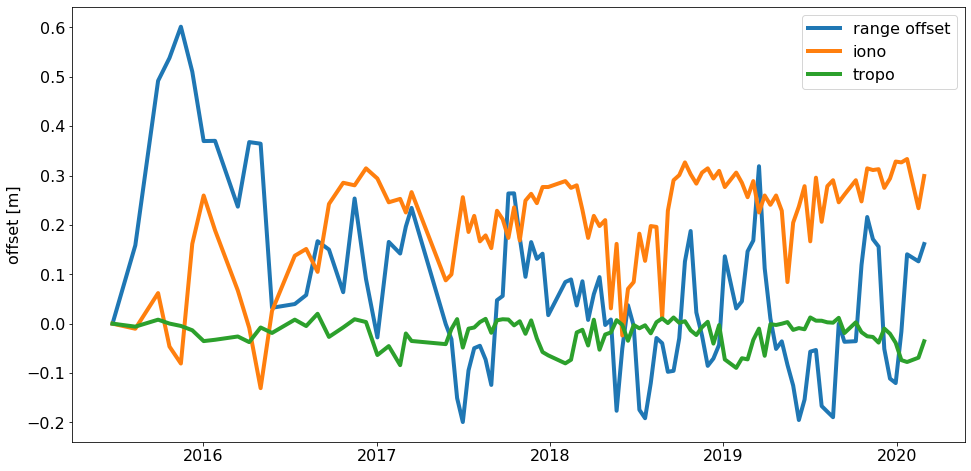

In [9]:
## plot
fig, ax = plt.subplots(figsize=[16, 8])
ax.plot(ts_obj.times, ts_off_med, linewidth=4, label='range offset')
ax.plot(ts_obj.times, -ts_iono,   linewidth=4, label='iono')
ax.plot(ts_obj.times, ts_tropo,   linewidth=4, label='tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()
plt.show()

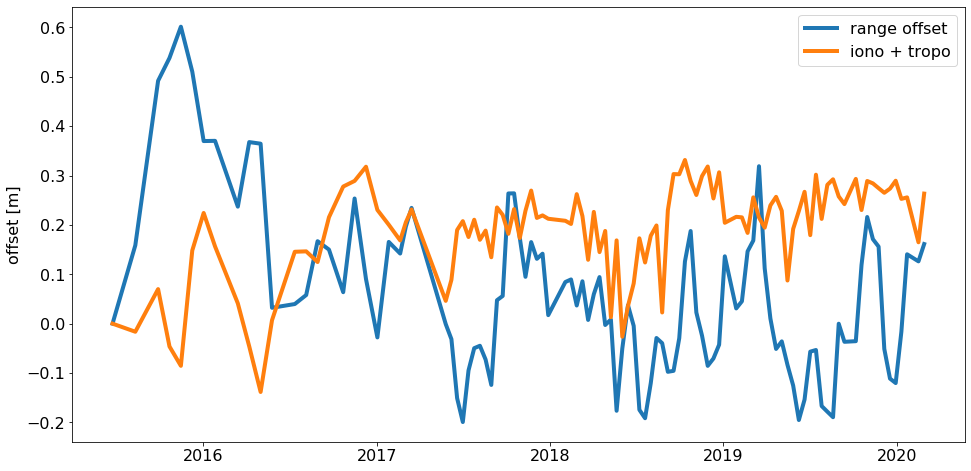

In [10]:
## plot
fig, ax = plt.subplots(figsize=[16, 8])
ax.plot(ts_obj.times, ts_off_med,          linewidth=4, label='range offset')
ax.plot(ts_obj.times, -ts_iono + ts_tropo, linewidth=4, label='iono + tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()
plt.show()